This notebook is a little easier for beginners because it uses pytorch. You need to clone a repo to get it working:

```sh
# you need this repo, so clone it
git clone https://github.com/wassname/DeepRL.git
cd DeepRL
git reset --hard aeae2c5d585e5853dc638968b1f090eb60abd351
cd ..
mkdir data log evaluation_log
```

This contains some minor modifications from https://github.com/ShangtongZhang/DeepRL.git

The notebook tries DPPG with the [EIIE model](https://arxiv.org/pdf/1706.10059.pdf)

I also uncommented reward normalization in DDPG_agent.py#L64 because otherwise my small reward les to large Q's, inf losses, and NaN actions and weights.

In [1]:
# plotting
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))
os.sys.path.append(os.path.abspath('DeepRL'))
%reload_ext autoreload
%autoreload 2

In [3]:
# params
window_length = 50
steps = 128



In [4]:
# save dir
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

save_path = './outputs/pytorch-DDPG/pytorch-DDPG-EIIE-action-crypto-%s.model' % ts
save_path
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass

In [5]:
# setup tensorboard logging
from tensorboard_logger import configure, log_value
tag = 'ddpg-' + ts
print('tensorboard --logdir '+"runs/" + tag)
try:
    configure("runs/" + tag)
except ValueError as e:
    print(e)
    pass

tensorboard --logdir runs/ddpg-20180330_16-20-25


# Env

In [6]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.util import MDD, sharpe, softmax
from rl_portfolio_management.wrappers import SoftmaxActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/bloomberg_30m.hf',key='train')
df_test = pd.read_hdf('./data/bloomberg_30m.hf',key='test')


In [7]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
        reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [8]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test():
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 16), (4, 51, 16))

# Agent and models

In [9]:
# load
import pickle
import shutil

def save_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    agent.save(save_file)
    print(save_file)
    

def load_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    new_states = pickle.load(open(save_file, 'rb'))
    states = agent.worker_network.load_state_dict(new_states)


def load_stats_ddpg(agent):
    agent_type = agent.__class__.__name__
    online_stats_file = 'data/%s-%s-online-stats-%s.bin' % (
                    agent_type, config.tag, agent.task.name)
    try:
        steps, rewards = pickle.load(open(online_stats_file, 'rb'))
    except FileNotFoundError:
        steps =[]
        rewards=[]
    df_online = pd.DataFrame(np.array([steps, rewards]).T, columns=['steps','rewards'])
    if len(df_online):
        df_online['step'] = df_online['steps'].cumsum()
        df_online.index.name = 'episodes'
    
    stats_file = 'data/%s-%s-all-stats-%s.bin' % (agent_type, config.tag, agent.task.name)
    try:
        stats = pickle.load(open(stats_file, 'rb'))
    except FileNotFoundError:
        stats = {}
    df = pd.DataFrame(stats["test_rewards"], columns=['rewards'])
    if len(df):
#         df["steps"]=range(len(df))*50

        df.index.name = 'episodes'
    return df_online, df

In [10]:
import logging
from agent import ProximalPolicyOptimization, DisjointActorCriticNet #, DeterministicActorNet, DeterministicCriticNet
from component import GaussianPolicy, HighDimActionReplay, OrnsteinUhlenbeckProcess
from utils import Config, Logger
import gym
import torch
gym.logger.setLevel(logging.INFO)

# Alg

In [11]:
# Modified from https://github.com/ShangtongZhang/DeepRL to log to tensorboard

from utils.normalizer import Normalizer

null_normaliser = lambda x:x

class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.task = config.task_fn()
        self.worker_network = config.network_fn()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.worker_network.state_dict())
        self.actor_opt = config.actor_optimizer_fn(self.worker_network.actor.parameters())
        self.critic_opt = config.critic_optimizer_fn(self.worker_network.critic.parameters())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn()
        self.criterion = nn.MSELoss()
        self.total_steps = 0

        self.state_normalizer = Normalizer(self.task.state_dim) # null_normaliser # 
        self.reward_normalizer = Normalizer(1)

    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.config.target_network_mix) +
                                    param.data * self.config.target_network_mix)

    def save(self, file_name):
        with open(file_name, 'wb') as f:
            torch.save(self.worker_network.state_dict(), f)

    def episode(self, deterministic=False, video_recorder=None):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.state_normalizer(state)

        config = self.config
        actor = self.worker_network.actor
        critic = self.worker_network.critic
        target_actor = self.target_network.actor
        target_critic = self.target_network.critic

        steps = 0
        total_reward = 0.0
        while True:
            actor.eval()
            action = actor.predict(np.stack([state])).flatten()
            if not deterministic:
                action += self.random_process.sample()
            next_state, reward, done, info = self.task.step(action)
            if video_recorder is not None:
                video_recorder.capture_frame()
            done = (done or (config.max_episode_length and steps >= config.max_episode_length))
            next_state = self.state_normalizer(next_state) * config.reward_scaling
            total_reward += reward
            
            # tensorboard logging
            prefix = 'test_' if deterministic else ''
            log_value(prefix + 'reward', reward, self.total_steps)
#             log_value(prefix + 'action', action, steps)
            log_value('memory_size', self.replay.size(), self.total_steps)     
            for key in info:
                log_value(key, info[key], self.total_steps)     
            
            reward = self.reward_normalizer(reward)

            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                self.total_steps += 1

            steps += 1
            state = next_state

            if done:
                break

            if not deterministic and self.replay.size() >= config.min_memory_size:
                self.worker_network.train()
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences
                q_next = target_critic.predict(next_states, target_actor.predict(next_states))
                terminals = critic.to_torch_variable(terminals).unsqueeze(1)
                rewards = critic.to_torch_variable(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                q = critic.predict(states, actions)
                critic_loss = self.criterion(q, q_next)

                critic.zero_grad()
                self.critic_opt.zero_grad()
                critic_loss.backward()
                if config.gradient_clip:
                    grad_critic = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.critic_opt.step()

                actions = actor.predict(states, False)
                var_actions = Variable(actions.data, requires_grad=True)
                q = critic.predict(states, var_actions)
                q.backward(torch.ones(q.size()))

                actor.zero_grad()
                self.actor_opt.zero_grad()
                actions.backward(-var_actions.grad.data)
                if config.gradient_clip:
                    grad_actor = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.actor_opt.step()
                
                # tensorboard logging
                log_value('critic_loss', critic_loss.cpu().data.numpy().squeeze(), self.total_steps)
                log_value('loss_action', -q.sum(), self.total_steps)
                if config.gradient_clip:
                    log_value('grad_critic', grad_critic, self.total_steps)
                    log_value('grad_actor', grad_actor, self.total_steps)

                self.soft_update(self.target_network, self.worker_network)

        return total_reward, steps

# Model

In [12]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [13]:
task.state_dim, task.action_dim

((4, 51, 16), 17)

In [14]:

from network.base_network import BasicNet

class DeterministicActorNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 action_gate,
                 action_scale,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicActorNet, self).__init__()

        stride_time = state_dim[1] - 1 - 2 #
        features = task.state_dim[0]
        h0 = 2
        h1 = 30
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.conv3 = nn.Conv2d((h1+1), 1, (1, 1))

        self.action_scale = action_scale
        self.action_gate = action_gate
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)

        self.batch_norm = batch_norm
        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x):
        x = self.to_torch_variable(x)
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        action = self.conv3(h)
        
        # add cash_bias before we softmax
        cash_bias_int = 0
        cash_bias = self.to_torch_variable(torch.ones(action.size())[:,:,:,:1] * cash_bias_int)
        action = torch.cat([cash_bias, action], -1)
        
        batch_size = action.size()[0]
        action = action.view((batch_size,-1))
        if self.action_gate:
            action = self.action_scale * self.action_gate(action)
        return action

    def predict(self, x, to_numpy=True):
        y = self.forward(x)
        if to_numpy:
            y = y.cpu().data.numpy()
        return y

class DeterministicCriticNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicCriticNet, self).__init__()
        stride_time = state_dim[1] - 1 - 2 #
        self.features = features = task.state_dim[0]
        h0=2
        h1=20
        self.action = actions = action_dim -1
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.layer3 = nn.Linear((h1+2)*actions, 1)
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)
        self.batch_norm = batch_norm

        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x, action):
        x = self.to_torch_variable(x)
        action = self.to_torch_variable(action)[:,None,None,:-1] # remove cash bias
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0,action], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        batch_size = x.size()[0]
        action = self.layer3(h.view((batch_size,-1)))
        return action

    def predict(self, x, action):
        return self.forward(x, action)

# Config

In [15]:
config = Config()
config.task_fn = task_fn
task = config.task_fn()
config.actor_network_fn = lambda: DeterministicActorNet(
    task.state_dim, task.action_dim, action_gate=None, action_scale=1.0, non_linear=F.relu, batch_norm=False, gpu=False)
config.critic_network_fn = lambda: DeterministicCriticNet(
    task.state_dim, task.action_dim, non_linear=F.relu, batch_norm=False, gpu=False)
config.network_fn = lambda: DisjointActorCriticNet(config.actor_network_fn, config.critic_network_fn)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=4e-5)
config.critic_optimizer_fn =\
    lambda params: torch.optim.Adam(params, lr=5e-4, weight_decay=0.001)
config.replay_fn = lambda: HighDimActionReplay(memory_size=600, batch_size=64)
config.random_process_fn = \
    lambda: OrnsteinUhlenbeckProcess(size=task.action_dim, theta=0.15, sigma=0.2, sigma_min=0.00002, n_steps_annealing=10000)
config.discount = 0.0

config.min_memory_size = 50
config.target_network_mix = 0.001
config.max_steps = 100000
config.max_episode_length = 3000
config.target_network_mix = 0.01
config.noise_decay_interval = 100000
config.gradient_clip = 20
config.min_epsilon = 0.1

# Many papers have found rewards scaling to be an important parameter. But while they focus on the scaling factor
# I think they should focus on the end variance with a range of 200-400. e.g. https://arxiv.org/pdf/1709.06560.pdf
# Hard to tell for sure without experiments to prove it
config.reward_scaling = 1000

config.test_interval = 10
config.test_repetitions = 1
config.save_interval = 40
config.logger = Logger('./log', gym.logger)
config.tag = tag
agent = DDPGAgent(config)
agent

# Train

In [16]:
from main import run_episodes
agent.task._plot = agent.task._plot2 = None
try:    
    run_episodes(agent)
except KeyboardInterrupt as e:
    save_ddpg(agent)
    raise(e)

INFO:gym:episode 1, reward 0.520963, avg reward 0.520963, total steps 128, episode step 128
[2018-03-30 17:20:35,025] episode 1, reward 0.520963, avg reward 0.520963, total steps 128, episode step 128
INFO:gym:episode 2, reward 0.572281, avg reward 0.546622, total steps 256, episode step 128
[2018-03-30 17:20:39,103] episode 2, reward 0.572281, avg reward 0.546622, total steps 256, episode step 128
INFO:gym:episode 3, reward -1.232545, avg reward -0.046434, total steps 384, episode step 128
[2018-03-30 17:20:42,622] episode 3, reward -1.232545, avg reward -0.046434, total steps 384, episode step 128
INFO:gym:episode 4, reward -0.292963, avg reward -0.108066, total steps 512, episode step 128
[2018-03-30 17:20:46,029] episode 4, reward -0.292963, avg reward -0.108066, total steps 512, episode step 128
INFO:gym:episode 5, reward -0.339408, avg reward -0.154334, total steps 640, episode step 128
[2018-03-30 17:20:49,154] episode 5, reward -0.339408, avg reward -0.154334, total steps 640, 

[2018-03-30 17:22:41,418] episode 38, reward -0.300716, avg reward -0.421494, total steps 4864, episode step 128
INFO:gym:episode 39, reward 0.147084, avg reward -0.406915, total steps 4992, episode step 128
[2018-03-30 17:22:44,729] episode 39, reward 0.147084, avg reward -0.406915, total steps 4992, episode step 128
INFO:gym:episode 40, reward -0.210906, avg reward -0.402015, total steps 5120, episode step 128
[2018-03-30 17:22:48,246] episode 40, reward -0.210906, avg reward -0.402015, total steps 5120, episode step 128
INFO:gym:Testing...
[2018-03-30 17:22:48,248] Testing...
INFO:gym:Avg reward -0.362491(0.000000)
[2018-03-30 17:22:48,798] Avg reward -0.362491(0.000000)
INFO:gym:episode 41, reward -0.314844, avg reward -0.399889, total steps 5248, episode step 128
[2018-03-30 17:22:52,164] episode 41, reward -0.314844, avg reward -0.399889, total steps 5248, episode step 128
INFO:gym:episode 42, reward -0.338419, avg reward -0.398425, total steps 5376, episode step 128
[2018-03-30 

INFO:gym:episode 75, reward -0.832209, avg reward -0.321491, total steps 9600, episode step 128
[2018-03-30 17:24:51,529] episode 75, reward -0.832209, avg reward -0.321491, total steps 9600, episode step 128
INFO:gym:episode 76, reward 1.424943, avg reward -0.298511, total steps 9728, episode step 128
[2018-03-30 17:24:54,892] episode 76, reward 1.424943, avg reward -0.298511, total steps 9728, episode step 128
INFO:gym:episode 77, reward 1.768415, avg reward -0.271668, total steps 9856, episode step 128
[2018-03-30 17:24:58,310] episode 77, reward 1.768415, avg reward -0.271668, total steps 9856, episode step 128
INFO:gym:episode 78, reward 1.833875, avg reward -0.244674, total steps 9984, episode step 128
[2018-03-30 17:25:01,691] episode 78, reward 1.833875, avg reward -0.244674, total steps 9984, episode step 128
INFO:gym:episode 79, reward -0.662964, avg reward -0.249969, total steps 10112, episode step 128
[2018-03-30 17:25:04,991] episode 79, reward -0.662964, avg reward -0.249

[2018-03-30 17:26:51,683] episode 111, reward 1.173203, avg reward 0.090800, total steps 14208, episode step 128
INFO:gym:episode 112, reward 2.352288, avg reward 0.117348, total steps 14336, episode step 128
[2018-03-30 17:26:55,332] episode 112, reward 2.352288, avg reward 0.117348, total steps 14336, episode step 128
INFO:gym:episode 113, reward -0.193724, avg reward 0.118962, total steps 14464, episode step 128
[2018-03-30 17:26:59,247] episode 113, reward -0.193724, avg reward 0.118962, total steps 14464, episode step 128
INFO:gym:episode 114, reward 1.202454, avg reward 0.133489, total steps 14592, episode step 128
[2018-03-30 17:27:02,406] episode 114, reward 1.202454, avg reward 0.133489, total steps 14592, episode step 128
INFO:gym:episode 115, reward 0.636219, avg reward 0.148413, total steps 14720, episode step 128
[2018-03-30 17:27:05,551] episode 115, reward 0.636219, avg reward 0.148413, total steps 14720, episode step 128
INFO:gym:episode 116, reward 1.538393, avg reward

[2018-03-30 17:28:56,785] episode 148, reward 0.185745, avg reward 0.515766, total steps 18944, episode step 128
INFO:gym:episode 149, reward -0.315281, avg reward 0.515966, total steps 19072, episode step 128
[2018-03-30 17:28:59,820] episode 149, reward -0.315281, avg reward 0.515966, total steps 19072, episode step 128
INFO:gym:episode 150, reward 1.329487, avg reward 0.532265, total steps 19200, episode step 128
[2018-03-30 17:29:02,827] episode 150, reward 1.329487, avg reward 0.532265, total steps 19200, episode step 128
INFO:gym:Testing...
[2018-03-30 17:29:02,828] Testing...
INFO:gym:Avg reward -0.674822(0.000000)
[2018-03-30 17:29:03,354] Avg reward -0.674822(0.000000)
INFO:gym:episode 151, reward 0.843964, avg reward 0.543163, total steps 19328, episode step 128
[2018-03-30 17:29:06,410] episode 151, reward 0.843964, avg reward 0.543163, total steps 19328, episode step 128
INFO:gym:episode 152, reward 1.528057, avg reward 0.561300, total steps 19456, episode step 128
[2018-03

INFO:gym:episode 185, reward -0.185641, avg reward 0.658703, total steps 23680, episode step 128
[2018-03-30 17:30:55,142] episode 185, reward -0.185641, avg reward 0.658703, total steps 23680, episode step 128
INFO:gym:episode 186, reward 1.664415, avg reward 0.678556, total steps 23808, episode step 128
[2018-03-30 17:30:58,378] episode 186, reward 1.664415, avg reward 0.678556, total steps 23808, episode step 128
INFO:gym:episode 187, reward 1.284080, avg reward 0.683919, total steps 23936, episode step 128
[2018-03-30 17:31:01,462] episode 187, reward 1.284080, avg reward 0.683919, total steps 23936, episode step 128
INFO:gym:episode 188, reward 0.429802, avg reward 0.668710, total steps 24064, episode step 128
[2018-03-30 17:31:05,328] episode 188, reward 0.429802, avg reward 0.668710, total steps 24064, episode step 128
INFO:gym:episode 189, reward 1.675231, avg reward 0.668465, total steps 24192, episode step 128
[2018-03-30 17:31:09,077] episode 189, reward 1.675231, avg reward

[2018-03-30 17:32:58,309] episode 221, reward 1.727404, avg reward 0.671187, total steps 28288, episode step 128
INFO:gym:episode 222, reward 2.707570, avg reward 0.687199, total steps 28416, episode step 128
[2018-03-30 17:33:01,465] episode 222, reward 2.707570, avg reward 0.687199, total steps 28416, episode step 128
INFO:gym:episode 223, reward 1.877480, avg reward 0.694936, total steps 28544, episode step 128
[2018-03-30 17:33:04,566] episode 223, reward 1.877480, avg reward 0.694936, total steps 28544, episode step 128
INFO:gym:episode 224, reward -1.632411, avg reward 0.673099, total steps 28672, episode step 128
[2018-03-30 17:33:07,597] episode 224, reward -1.632411, avg reward 0.673099, total steps 28672, episode step 128
INFO:gym:episode 225, reward 0.138444, avg reward 0.656442, total steps 28800, episode step 128
[2018-03-30 17:33:10,750] episode 225, reward 0.138444, avg reward 0.656442, total steps 28800, episode step 128
INFO:gym:episode 226, reward 0.212775, avg reward

[2018-03-30 17:35:02,404] episode 258, reward 2.712177, avg reward 0.582504, total steps 33024, episode step 128
INFO:gym:episode 259, reward 0.387285, avg reward 0.593123, total steps 33152, episode step 128
[2018-03-30 17:35:05,602] episode 259, reward 0.387285, avg reward 0.593123, total steps 33152, episode step 128
INFO:gym:episode 260, reward -0.841455, avg reward 0.569524, total steps 33280, episode step 128
[2018-03-30 17:35:08,818] episode 260, reward -0.841455, avg reward 0.569524, total steps 33280, episode step 128
INFO:gym:Testing...
[2018-03-30 17:35:08,822] Testing...
INFO:gym:Avg reward 1.715388(0.000000)
[2018-03-30 17:35:09,321] Avg reward 1.715388(0.000000)
INFO:gym:episode 261, reward 0.027866, avg reward 0.543660, total steps 33408, episode step 128
[2018-03-30 17:35:12,684] episode 261, reward 0.027866, avg reward 0.543660, total steps 33408, episode step 128
INFO:gym:episode 262, reward 1.302591, avg reward 0.536299, total steps 33536, episode step 128
[2018-03-3

INFO:gym:episode 295, reward 1.307474, avg reward 0.565405, total steps 37760, episode step 128
[2018-03-30 17:37:04,179] episode 295, reward 1.307474, avg reward 0.565405, total steps 37760, episode step 128
INFO:gym:episode 296, reward 0.664210, avg reward 0.572000, total steps 37888, episode step 128
[2018-03-30 17:37:07,366] episode 296, reward 0.664210, avg reward 0.572000, total steps 37888, episode step 128
INFO:gym:episode 297, reward 1.140281, avg reward 0.577998, total steps 38016, episode step 128
[2018-03-30 17:37:10,425] episode 297, reward 1.140281, avg reward 0.577998, total steps 38016, episode step 128
INFO:gym:episode 298, reward 1.126776, avg reward 0.606529, total steps 38144, episode step 128
[2018-03-30 17:37:13,666] episode 298, reward 1.126776, avg reward 0.606529, total steps 38144, episode step 128
INFO:gym:episode 299, reward 0.763865, avg reward 0.613441, total steps 38272, episode step 128
[2018-03-30 17:37:16,729] episode 299, reward 0.763865, avg reward 0

[2018-03-30 17:39:46,551] episode 331, reward -0.207972, avg reward 0.537946, total steps 42368, episode step 128
INFO:gym:episode 332, reward 0.416073, avg reward 0.554984, total steps 42496, episode step 128
[2018-03-30 17:39:52,442] episode 332, reward 0.416073, avg reward 0.554984, total steps 42496, episode step 128
INFO:gym:episode 333, reward -1.418563, avg reward 0.522899, total steps 42624, episode step 128
[2018-03-30 17:39:58,095] episode 333, reward -1.418563, avg reward 0.522899, total steps 42624, episode step 128
INFO:gym:episode 334, reward 0.909024, avg reward 0.519853, total steps 42752, episode step 128
[2018-03-30 17:40:04,314] episode 334, reward 0.909024, avg reward 0.519853, total steps 42752, episode step 128
INFO:gym:episode 335, reward -1.162036, avg reward 0.504497, total steps 42880, episode step 128
[2018-03-30 17:40:10,533] episode 335, reward -1.162036, avg reward 0.504497, total steps 42880, episode step 128
INFO:gym:episode 336, reward 0.322358, avg rew

[2018-03-30 17:42:47,633] episode 368, reward -0.015889, avg reward 0.577218, total steps 47104, episode step 128
INFO:gym:episode 369, reward -0.612495, avg reward 0.587622, total steps 47232, episode step 128
[2018-03-30 17:42:52,054] episode 369, reward -0.612495, avg reward 0.587622, total steps 47232, episode step 128
INFO:gym:episode 370, reward 0.888005, avg reward 0.574663, total steps 47360, episode step 128
[2018-03-30 17:42:56,925] episode 370, reward 0.888005, avg reward 0.574663, total steps 47360, episode step 128
INFO:gym:Testing...
[2018-03-30 17:42:56,926] Testing...
INFO:gym:Avg reward 2.424363(0.000000)
[2018-03-30 17:42:57,446] Avg reward 2.424363(0.000000)
INFO:gym:episode 371, reward 0.035511, avg reward 0.564299, total steps 47488, episode step 128
[2018-03-30 17:43:02,149] episode 371, reward 0.035511, avg reward 0.564299, total steps 47488, episode step 128
INFO:gym:episode 372, reward 1.411996, avg reward 0.564519, total steps 47616, episode step 128
[2018-03-

INFO:gym:episode 405, reward 0.763782, avg reward 0.512221, total steps 51840, episode step 128
[2018-03-30 17:45:32,296] episode 405, reward 0.763782, avg reward 0.512221, total steps 51840, episode step 128
INFO:gym:episode 406, reward -1.376113, avg reward 0.478896, total steps 51968, episode step 128
[2018-03-30 17:45:37,174] episode 406, reward -1.376113, avg reward 0.478896, total steps 51968, episode step 128
INFO:gym:episode 407, reward -0.435114, avg reward 0.449492, total steps 52096, episode step 128
[2018-03-30 17:45:42,402] episode 407, reward -0.435114, avg reward 0.449492, total steps 52096, episode step 128
INFO:gym:episode 408, reward 1.182149, avg reward 0.462316, total steps 52224, episode step 128
[2018-03-30 17:45:47,883] episode 408, reward 1.182149, avg reward 0.462316, total steps 52224, episode step 128
INFO:gym:episode 409, reward -1.929849, avg reward 0.432098, total steps 52352, episode step 128
[2018-03-30 17:45:53,627] episode 409, reward -1.929849, avg re

[2018-03-30 17:48:55,169] episode 441, reward -2.075485, avg reward 0.417845, total steps 56448, episode step 128
INFO:gym:episode 442, reward 1.269999, avg reward 0.413228, total steps 56576, episode step 128
[2018-03-30 17:49:00,769] episode 442, reward 1.269999, avg reward 0.413228, total steps 56576, episode step 128
INFO:gym:episode 443, reward 1.236490, avg reward 0.415427, total steps 56704, episode step 128
[2018-03-30 17:49:06,909] episode 443, reward 1.236490, avg reward 0.415427, total steps 56704, episode step 128
INFO:gym:episode 444, reward 0.108450, avg reward 0.418404, total steps 56832, episode step 128
[2018-03-30 17:49:13,016] episode 444, reward 0.108450, avg reward 0.418404, total steps 56832, episode step 128
INFO:gym:episode 445, reward 0.672583, avg reward 0.409646, total steps 56960, episode step 128
[2018-03-30 17:49:19,746] episode 445, reward 0.672583, avg reward 0.409646, total steps 56960, episode step 128
INFO:gym:episode 446, reward 0.871160, avg reward 

[2018-03-30 17:51:54,360] episode 478, reward -1.222170, avg reward 0.493750, total steps 61184, episode step 128
INFO:gym:episode 479, reward 1.566532, avg reward 0.482598, total steps 61312, episode step 128
[2018-03-30 17:51:58,506] episode 479, reward 1.566532, avg reward 0.482598, total steps 61312, episode step 128
INFO:gym:episode 480, reward 0.861609, avg reward 0.481167, total steps 61440, episode step 128
[2018-03-30 17:52:02,863] episode 480, reward 0.861609, avg reward 0.481167, total steps 61440, episode step 128
INFO:gym:Testing...
[2018-03-30 17:52:02,867] Testing...
INFO:gym:Avg reward 1.084897(0.000000)
[2018-03-30 17:52:03,378] Avg reward 1.084897(0.000000)
INFO:gym:episode 481, reward 0.104988, avg reward 0.472802, total steps 61568, episode step 128
[2018-03-30 17:52:07,535] episode 481, reward 0.104988, avg reward 0.472802, total steps 61568, episode step 128
INFO:gym:episode 482, reward 1.154595, avg reward 0.468373, total steps 61696, episode step 128
[2018-03-30

INFO:gym:episode 515, reward -0.587745, avg reward 0.539312, total steps 65920, episode step 128
[2018-03-30 17:55:16,311] episode 515, reward -0.587745, avg reward 0.539312, total steps 65920, episode step 128
INFO:gym:episode 516, reward 1.363723, avg reward 0.547168, total steps 66048, episode step 128
[2018-03-30 17:55:20,855] episode 516, reward 1.363723, avg reward 0.547168, total steps 66048, episode step 128
INFO:gym:episode 517, reward -0.473669, avg reward 0.538694, total steps 66176, episode step 128
[2018-03-30 17:55:25,149] episode 517, reward -0.473669, avg reward 0.538694, total steps 66176, episode step 128
INFO:gym:episode 518, reward 1.495870, avg reward 0.539506, total steps 66304, episode step 128
[2018-03-30 17:55:29,322] episode 518, reward 1.495870, avg reward 0.539506, total steps 66304, episode step 128
INFO:gym:episode 519, reward -1.626325, avg reward 0.506387, total steps 66432, episode step 128
[2018-03-30 17:55:33,504] episode 519, reward -1.626325, avg re

[2018-03-30 17:58:05,894] episode 551, reward 0.082925, avg reward 0.564808, total steps 70528, episode step 128
INFO:gym:episode 552, reward -0.116144, avg reward 0.546962, total steps 70656, episode step 128
[2018-03-30 17:58:09,706] episode 552, reward -0.116144, avg reward 0.546962, total steps 70656, episode step 128
INFO:gym:episode 553, reward 1.636803, avg reward 0.546335, total steps 70784, episode step 128
[2018-03-30 17:58:13,625] episode 553, reward 1.636803, avg reward 0.546335, total steps 70784, episode step 128
INFO:gym:episode 554, reward 2.098209, avg reward 0.564293, total steps 70912, episode step 128
[2018-03-30 17:58:17,650] episode 554, reward 2.098209, avg reward 0.564293, total steps 70912, episode step 128
INFO:gym:episode 555, reward 0.553516, avg reward 0.553947, total steps 71040, episode step 128
[2018-03-30 17:58:21,712] episode 555, reward 0.553516, avg reward 0.553947, total steps 71040, episode step 128
INFO:gym:episode 556, reward 0.984059, avg reward

[2018-03-30 18:00:59,057] episode 588, reward 1.657834, avg reward 0.601919, total steps 75264, episode step 128
INFO:gym:episode 589, reward 0.435339, avg reward 0.604435, total steps 75392, episode step 128
[2018-03-30 18:01:05,896] episode 589, reward 0.435339, avg reward 0.604435, total steps 75392, episode step 128
INFO:gym:episode 590, reward 1.589625, avg reward 0.615408, total steps 75520, episode step 128
[2018-03-30 18:01:12,481] episode 590, reward 1.589625, avg reward 0.615408, total steps 75520, episode step 128
INFO:gym:Testing...
[2018-03-30 18:01:12,483] Testing...
INFO:gym:Avg reward 1.311645(0.000000)
[2018-03-30 18:01:13,011] Avg reward 1.311645(0.000000)
INFO:gym:episode 591, reward 0.487145, avg reward 0.593360, total steps 75648, episode step 128
[2018-03-30 18:01:19,603] episode 591, reward 0.487145, avg reward 0.593360, total steps 75648, episode step 128
INFO:gym:episode 592, reward 0.048842, avg reward 0.575900, total steps 75776, episode step 128
[2018-03-30 

INFO:gym:episode 625, reward 1.054048, avg reward 0.549285, total steps 80000, episode step 128
[2018-03-30 18:04:16,176] episode 625, reward 1.054048, avg reward 0.549285, total steps 80000, episode step 128
INFO:gym:episode 626, reward 0.344548, avg reward 0.545228, total steps 80128, episode step 128
[2018-03-30 18:04:21,229] episode 626, reward 0.344548, avg reward 0.545228, total steps 80128, episode step 128
INFO:gym:episode 627, reward -1.697601, avg reward 0.523160, total steps 80256, episode step 128
[2018-03-30 18:04:26,447] episode 627, reward -1.697601, avg reward 0.523160, total steps 80256, episode step 128
INFO:gym:episode 628, reward 1.266733, avg reward 0.538940, total steps 80384, episode step 128
[2018-03-30 18:04:32,183] episode 628, reward 1.266733, avg reward 0.538940, total steps 80384, episode step 128
INFO:gym:episode 629, reward 1.130417, avg reward 0.543033, total steps 80512, episode step 128
[2018-03-30 18:04:36,409] episode 629, reward 1.130417, avg reward

[2018-03-30 18:06:55,799] episode 661, reward 0.213485, avg reward 0.502499, total steps 84608, episode step 128
INFO:gym:episode 662, reward 0.728026, avg reward 0.500222, total steps 84736, episode step 128
[2018-03-30 18:06:59,590] episode 662, reward 0.728026, avg reward 0.500222, total steps 84736, episode step 128
INFO:gym:episode 663, reward 0.689212, avg reward 0.504355, total steps 84864, episode step 128
[2018-03-30 18:07:03,645] episode 663, reward 0.689212, avg reward 0.504355, total steps 84864, episode step 128
INFO:gym:episode 664, reward 1.368946, avg reward 0.510635, total steps 84992, episode step 128
[2018-03-30 18:07:07,595] episode 664, reward 1.368946, avg reward 0.510635, total steps 84992, episode step 128
INFO:gym:episode 665, reward -2.100477, avg reward 0.461771, total steps 85120, episode step 128
[2018-03-30 18:07:11,436] episode 665, reward -2.100477, avg reward 0.461771, total steps 85120, episode step 128
INFO:gym:episode 666, reward 1.957307, avg reward

[2018-03-30 18:10:04,491] episode 698, reward 0.128934, avg reward 0.339507, total steps 89344, episode step 128
INFO:gym:episode 699, reward -1.132826, avg reward 0.310997, total steps 89472, episode step 128
[2018-03-30 18:10:11,008] episode 699, reward -1.132826, avg reward 0.310997, total steps 89472, episode step 128
INFO:gym:episode 700, reward 1.808645, avg reward 0.300656, total steps 89600, episode step 128
[2018-03-30 18:10:17,994] episode 700, reward 1.808645, avg reward 0.300656, total steps 89600, episode step 128
INFO:gym:Testing...
[2018-03-30 18:10:17,998] Testing...
INFO:gym:Avg reward 2.047487(0.000000)
[2018-03-30 18:10:18,510] Avg reward 2.047487(0.000000)
INFO:gym:episode 701, reward -2.285194, avg reward 0.269589, total steps 89728, episode step 128
[2018-03-30 18:10:25,193] episode 701, reward -2.285194, avg reward 0.269589, total steps 89728, episode step 128
INFO:gym:episode 702, reward 1.649325, avg reward 0.272690, total steps 89856, episode step 128
[2018-03

INFO:gym:episode 735, reward 1.026170, avg reward 0.253402, total steps 94080, episode step 128
[2018-03-30 18:13:33,784] episode 735, reward 1.026170, avg reward 0.253402, total steps 94080, episode step 128
INFO:gym:episode 736, reward 1.905831, avg reward 0.265477, total steps 94208, episode step 128
[2018-03-30 18:13:38,377] episode 736, reward 1.905831, avg reward 0.265477, total steps 94208, episode step 128
INFO:gym:episode 737, reward 1.066896, avg reward 0.272142, total steps 94336, episode step 128
[2018-03-30 18:13:42,680] episode 737, reward 1.066896, avg reward 0.272142, total steps 94336, episode step 128
INFO:gym:episode 738, reward -0.414665, avg reward 0.253104, total steps 94464, episode step 128
[2018-03-30 18:13:47,099] episode 738, reward -0.414665, avg reward 0.253104, total steps 94464, episode step 128
INFO:gym:episode 739, reward 0.674755, avg reward 0.250488, total steps 94592, episode step 128
[2018-03-30 18:13:52,806] episode 739, reward 0.674755, avg reward

[2018-03-30 18:16:13,251] episode 771, reward 0.725349, avg reward 0.403189, total steps 98688, episode step 128
INFO:gym:episode 772, reward 1.334015, avg reward 0.418493, total steps 98816, episode step 128
[2018-03-30 18:16:18,871] episode 772, reward 1.334015, avg reward 0.418493, total steps 98816, episode step 128
INFO:gym:episode 773, reward -2.185031, avg reward 0.411157, total steps 98944, episode step 128
[2018-03-30 18:16:24,729] episode 773, reward -2.185031, avg reward 0.411157, total steps 98944, episode step 128
INFO:gym:episode 774, reward 1.094068, avg reward 0.418262, total steps 99072, episode step 128
[2018-03-30 18:16:30,625] episode 774, reward 1.094068, avg reward 0.418262, total steps 99072, episode step 128
INFO:gym:episode 775, reward 1.397938, avg reward 0.440080, total steps 99200, episode step 128
[2018-03-30 18:16:36,416] episode 775, reward 1.397938, avg reward 0.440080, total steps 99200, episode step 128
INFO:gym:episode 776, reward -1.591141, avg rewar

# History

In [17]:
# plot rewards
plt.figure()
df_online, df = load_stats_ddpg(agent)
sns.regplot(x="step", y="rewards", data=df_online, order=1)

<IPython.core.display.Javascript object>

In [18]:
# monthly growth
portfolio_return = (1+df_online.rewards[-100:].mean())

returns = task.unwrapped.src.data[0,:,:1]
market_return = (1+returns).mean()
market_return, portfolio_return

(157.19563, 1.3518236864856914)

# Test

In [19]:
def test_algo(env, algo, seed=0):
    """
    Runs and algo from https://github.com/Marigold/universal-portfolios on env
    
    https://github.com/Marigold/universal-portfolios/commit/e8970a82427522ef11b1c3cbf681e18b5fe8169c
    """
    env.seed(0)
    np.random.seed(0)

    state = env.reset()
    for i in range(env.unwrapped.sim.steps):
        
        history= pd.DataFrame(state[0,:,:], columns=env.unwrapped.src.asset_names)
        # MPT wants a cash column, and it should be first
        history['CASH']=1
        history=history[['CASH'] + env.unwrapped.src.asset_names]
#         cols = list(history.columns)
#         cols[0]='CASH'
#         history.columns = cols
        
        x=history.iloc[-1]
        
        last_b = env.unwrapped.sim.w0#[1:]

        algo.init_step(history)
        # some don't want history
        try:
            action = algo.step(x, last_b, history)
        except TypeError:
            action = algo.step(x, last_b)
        
        # might by dataframe
        action = getattr(action, 'value', action)
        
        # For upt
        if isinstance(action, np.matrixlib.defmatrix.matrix):
            action = np.array(action.tolist()).T[0]
            
        

        state, reward, done, info = env.step(action)

        if done:
            break   
    df = pd.DataFrame(env.unwrapped.infos)
    df.index = pd.to_datetime(df['date']*1e9)
    return df['portfolio_value'], df

<IPython.core.display.Javascript object>


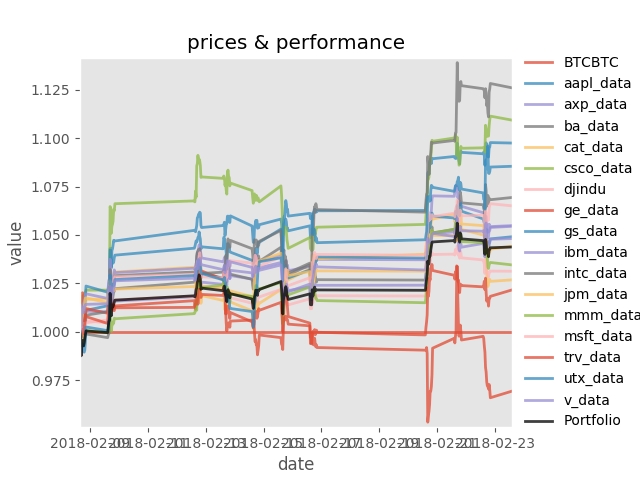

<IPython.core.display.Javascript object>


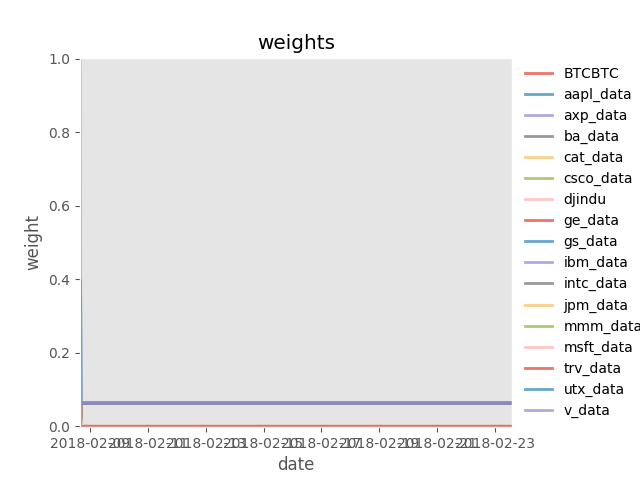

<IPython.core.display.Javascript object>


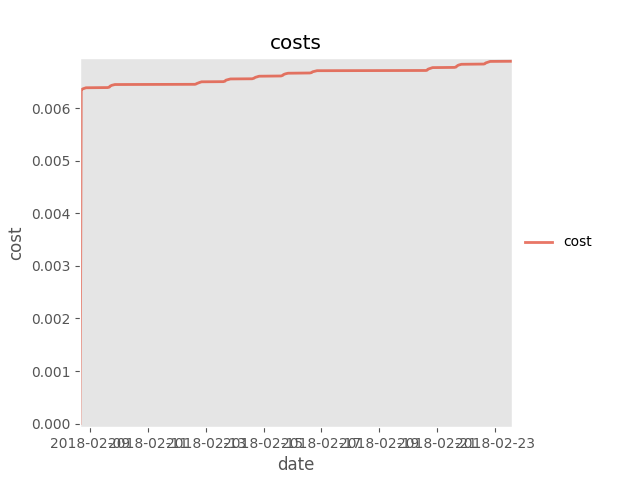

In [20]:
# use test env
df_test = pd.read_hdf('./data/bloomberg_30m.hf',key='test')
test_steps=10000
env_test = task_fn_test()
agent.task = env_test
agent.config.max_episode_length = test_steps
agent.task.reset()
np.random.seed(0)

# run in deterministic mode, no training, no exploration
agent.episode(True)
agent.task.render('notebook')
agent.task.render('notebook', True)

df = pd.DataFrame(agent.task.unwrapped.infos)
df.index = pd.to_datetime(df['date']*1e9)

In [21]:
from universal import algos
env = task.unwrapped
price_cols = [col for col in df.columns if col.startswith('price')]
for col in price_cols:
    df[col]=df[col].cumprod()

df = df[price_cols + ['portfolio_value']]
    
algo_dict=dict(
    # Pick the same is in https://arxiv.org/pdf/1706.10059.pdf
    # Benchmarks
#     UCRP=algos.UP(),
    
    # Follow the winner
    BestSoFar=algos.BestSoFar(cov_window=env_test.unwrapped.src.window_length-1),
#     UniversalPortfolio=algos.UP(eval_points=1000),
    ONS=algos.ONS(),
    
    # Follow the loser
#     OnlineMovingAverageReversion=algos.OLMAR(window=env.src.window_length-1, eps=10), 
    RMR=algos.RMR(window=env_test.unwrapped.src.window_length-1, eps=10),
#     PassiveAggressiveMeanReversion=algos.PAMR(),
    
    # Pattern matching
    #     CorrelationDrivenNonparametricLearning=algos.CORN(window=30),
)
for name, algo in algo_dict.items():
    print(name)
    perf, _ = test_algo(env_test, algo)
    perf.index=df.index
    df[name]=perf

# put portfolio value at end so we plot it on top and can therefore see it
cols = list(df.columns.drop('portfolio_value'))+['portfolio_value']
df=df[cols]


df.plot(alpha=0.5)

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: No module named 'sklearn'